In [1]:
import csv
import glob
import re
import pandas as pd
import numpy as np
from functools import reduce
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os, codecs, string, random
import seaborn as sns
sns.set()
#NLP libraries
import spacy, nltk, gensim, sklearn
# sklearn packages
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.externals import joblib
from xgboost import XGBClassifier
# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

ModuleNotFoundError: No module named 'spacy'

SyntaxError: invalid syntax (<ipython-input-9-85411089d22c>, line 1)

In [13]:
# Getting all the required file for cleaning and predictions
rep_file = "Input/df_replacement_fr.csv"
channel_file = "Input/Channel_selected_fr.csv"
stop_file = "Input/df_stopwords_fr.csv"
# Getting the wanted word for dictionary
replacement = pd.read_csv(rep_file, encoding ='latin-1' ).drop(["old","new"],axis =1)
channel = pd.read_csv(channel_file, encoding ='latin-1' ).drop(["Channel_selected","ChannelName","ChannelName_clean"], axis=1)
stopwords_list = pd.read_csv(stop_file, encoding ='latin-1' ).drop("type", axis = 1).rename(columns={"translation":"old"})
frames = [replacement, channel]
result = pd.concat(frames)
result = result.dropna()
dico = dict(zip(result.trans_old, result.trans_new))
stop_words1 =  stopwords.words('french') + ['projet', "dévelopement","programme", 'pays',"sustainable","gouvernement",'national','international','plus',
              'durable','sdg'] + list(stopwords_list["old"].values)

In [14]:
import spacy
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = FrenchLefffLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('french') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        doc_tok = [x for x in doc_tok if x not in stop_words1]
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        doc = [self.wnl.lemmatize(t) for t in doc_tok]
        # uncomment if you want stemming as well
        doc = [self.stemmer.stem(x) for x in doc]
        return doc

In [15]:
def old_new_replace(s, dico):
    """
   Replaces word in a string to the new wanted word in the dictionary
    INPUT: -s (string): string we want to modify the given word
           -dico (dict): list of word and their replace new word.
    OUTPUT: - (string): 
    """
    new_s = s
    for old, new in dico.items():
        new_s = new_s.replace(old, new)
    return new_s

In [16]:
#Getting the final trainset, 
train_file = "Input/final_trainset.csv"

train = pd.read_csv("Input/final_trainset.csv")

In [17]:
# CountVectorizer instantiation with stop words, setting to count words of 1-grams and do not filter words based on their frequency
count_vec = CountVectorizer(lowercase=True,min_df=1,analyzer='word',tokenizer = LemmaTokenizer(), ngram_range=(1,2))#tokenizer = LemmaTokenizer()
vect_word = TfidfVectorizer(lowercase=True,min_df=1,analyzer='word',tokenizer = LemmaTokenizer(),ngram_range=(1,2))#tokenizer = LemmaTokenizer()
fit = train["new text"]
feat = vect_word.fit_transform(fit.values)
feat_name = vect_word.get_feature_names()


In [7]:
des = ["No Poverty", "Zero Hunger", "Good Health and well-being", 'Quality Education', "Gender Equality",
                   "Clean Water and Sanitation", "Affordable and Clean Energy", 'Decent Work and Economic growth',
                   "Industry, Innovation and Infrastructure", "Reduced Inequality", "Sustainable cities and communities",
                   "Responsible Consumption and Production", 'Climate Action', 'Life below water',"Life on land","Peace justice and  strong Institutions","Partnernship for the goals"]

In [8]:
 color = ["#e5243b", "#dda63a", "#4c9f38", "#c5192d", "#ff3a21", "#26bde2", "#fcc30b", "#a21942", 
              "#fd6925", "#dd1367", "#fd9d24", "#bf8b2e", "#3f7e44", "#0a97d9", "#56c02b", "#00689d",
              "#19486a"]

In [9]:
def single_pred(path,name,column):
    """
    Takes a given csv documents and output the predicted probability for each entries. Then given our predicted probability
    and chosen tresholds, functions creates a barplot giving the percentage of mention for each SDG in the given document.
    INPUT: -path (string): path that contain the waned document.
           -name (string): name of the csv document to be used for predictions.
           -column(string): name of the column you want to use for predictions
    OUTPUT: - (csv file): file containing the predicted probability for each class
            - (jpg): jpg file showing the SDG's mention (in %) for the whole document.
    """
    target_col = ["SDG{}".format(i) for i in range(1,18)]
    #treshold_file ="Saved_Fit/Treshold.csv"
    treshold_file ="Saved_Fit/Treshold.csv"
    
    treshold = pd.read_csv(treshold_file)
    tres = list(treshold["Tresholds"].values)
    # For AFD documents penalise more the SDG17 and SDG8
    tres[16] = 0.5
    tres[7] = 0.5
    
    file_name = name.strip("Table_").strip(".pdf.csv")
    test = pd.read_csv(os.path.join(path, name), encoding ='utf8' ).rename(columns={column:"text"})
    #display(new_test)
    for col in ['text']:
        test[col] = test[col].str.lower()
    test["new text"] = test["text"].apply(lambda x: old_new_replace(x,dico))
    tr_test = test["new text"]
    mat_pred = vect_word.transform(tr_test.values)
    #test_char = vect_char.transform(test["text"])
    #mat_pred =  sparse.hstack([test_vect])
    test_proba = pd.DataFrame()
    test_proba["Index"] = test.text.values
    for j,col in enumerate(target_col):
        # load model from file
        fit_name = 'Saved_Fit/Model_Fit_{}.joblib'.format(col)
        loaded_model = joblib.load(fit_name)
        # make predictions for test data
        test_proba[col] = loaded_model.predict_proba(mat_pred)[:,1]
    
    pred_SDG = pd.DataFrame()
    pred_SDG["Index"] = test_proba["Index"]
    for l in range(1,18):
        pred_SDG["SDG{}".format(l)] = 0
    for j in range(1,18):
        for i in range(len(test_proba)):
            if test_proba["SDG{}".format(j)][i] > tres[j-1]:
                pred_SDG["SDG{}".format(j)][i]  = 1
            else:
                pred_SDG["SDG{}".format(j)][i] = 0
    pred_SDG.to_csv("Predictions_{}.csv".format(file_name))
    pred_SDG = pred_SDG.drop("Index", axis =1)
    d = 0
    for i in range(len(pred_SDG)):
        if np.isin(1,pred_SDG.iloc[i].values) == True:
            d += 1
    count = (pred_SDG.sum()/d)*100

    plt.figure(figsize=(18,10))
    plt.bar(des,count,color = color, label="Presence of SDG's")
    plt.xticks(rotation = 80)
    plt.title("Count of SDG's for {}".format(file_name))
    plt.legend()
    plt.tight_layout()
    plt.savefig("SDG_{}.png".format(file_name), bbox_inches='tight')
    plt.show()



In [10]:
path = input("Step1: Insert Path file Name :")#C:\Users\marco\Desktop\Desktop\Test
file = input("Step2: Insert  file Name :")#Table_Stratégie Régionale Afrique de l'Est pour CI.csv
column = input("Step3: Insert column to be predicted :")#Kept sentences

Step1: Insert Path file Name : C:\Users\marco\Desktop\Desktop\Test
Step2: Insert  file Name : Table_Stratégie Régionale Afrique de l'Est pour CI.csv
Step3: Insert column to be predicted : Kept sentences


C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


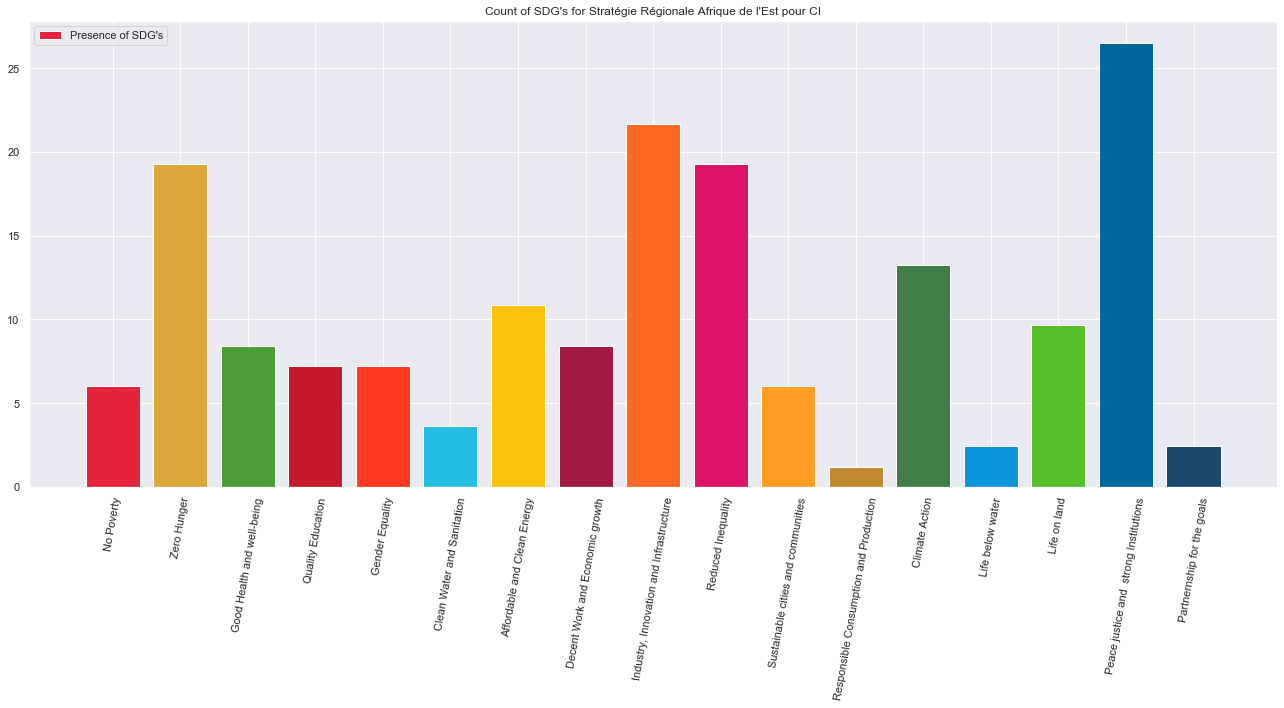

In [11]:
single_pred(path,file,column)